In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import os
import cv2
import sys
from pylab import rcParams
from PIL import Image
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Input, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import VGG16, InceptionV3, Xception, EfficientNetB3
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy) #shortens training time by 2x

In [3]:
df_train = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
df_train.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [4]:
df_train["label"] = df_train["label"].astype(str) #convert to str as we want to use Categorical Cross Entropy (CCE) later on
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  object
dtypes: object(2)
memory usage: 334.5+ KB


## Exploratory Data Analysis

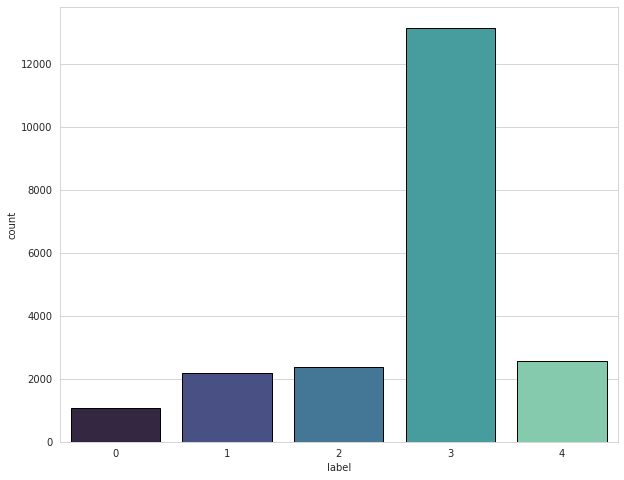

In [5]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,8))
sns.countplot(df_train["label"], edgecolor="black", palette="mako", order=['0','1','2','3','4'])
plt.show()

Label 0: Cassava Bacterial Blight (CBB)

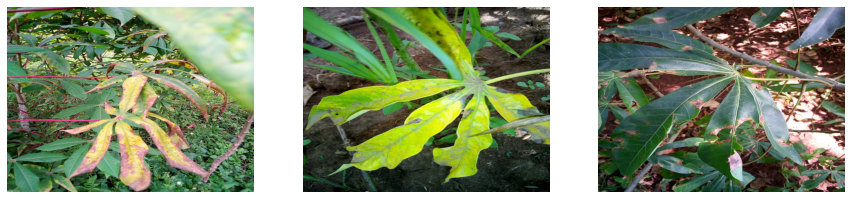

In [6]:
path = "../input/cassava-leaf-disease-classification/train_images/"
df0 = df_train[df_train["label"] == "0"]
files = df0["image_id"].sample(3).tolist()

plt.figure(figsize=(15,5))
index = 0
for file in files:
    image = Image.open(path + file)
    plt.subplot(1, 3, index + 1)
    plt.imshow(image)
    plt.axis("off")
    index += 1

plt.show()

Label 1: Cassava Brown Streak Disease (CBSD)

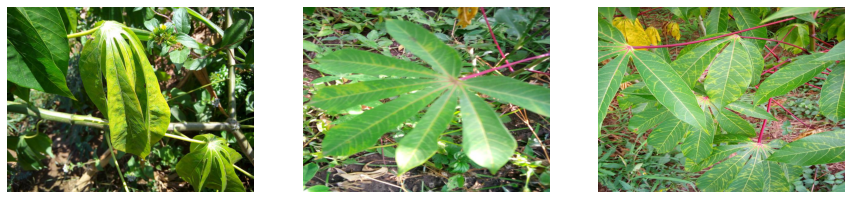

In [7]:
df1 = df_train[df_train["label"] == "1"]
files = df1["image_id"].sample(3).tolist()

plt.figure(figsize=(15,5))
index = 0
for file in files:
    image = Image.open(path + file)
    plt.subplot(1, 3, index + 1)
    plt.imshow(image)
    plt.axis("off")
    index += 1

plt.show()

Label 2: Cassava Green Mottle (CGM)

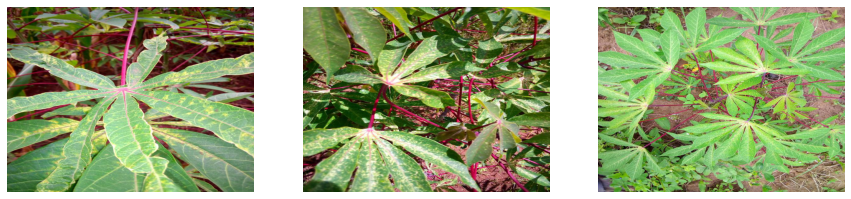

In [8]:
df2 = df_train[df_train["label"] == "2"]
files = df2["image_id"].sample(3).tolist()

plt.figure(figsize=(15,5))
index = 0
for file in files:
    image = Image.open(path + file)
    plt.subplot(1, 3, index + 1)
    plt.imshow(image)
    plt.axis("off")
    index += 1

plt.show()

Label 3: Cassava Mosiac Disease (CMD)

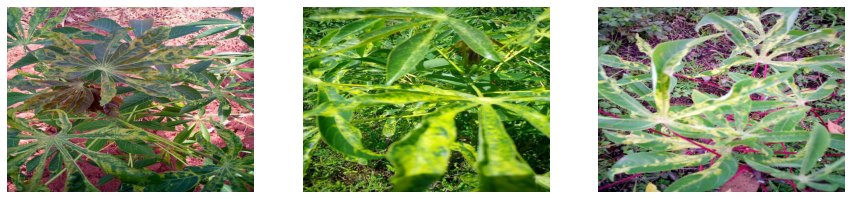

In [9]:
df3 = df_train[df_train["label"] == "3"]
files = df3["image_id"].sample(3).tolist()

plt.figure(figsize=(15,5))
index = 0
for file in files:
    image = Image.open(path + file)
    plt.subplot(1, 3, index + 1)
    plt.imshow(image)
    plt.axis("off")
    index += 1

plt.show()

Label 4: Healthy

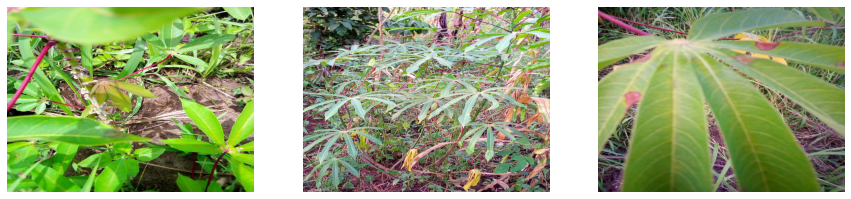

In [10]:
df4 = df_train[df_train["label"] == "4"]
files = df4["image_id"].sample(3).tolist()

plt.figure(figsize=(15,5))
index = 0
for file in files:
    image = Image.open(path + file)
    plt.subplot(1, 3, index + 1)
    plt.imshow(image)
    plt.axis("off")
    index += 1

plt.show()

## Image Augmentation (Tensorflow)

In [11]:
batch_size=16
image_size=300

input_shape = (image_size, image_size, 3)
target_size = (image_size, image_size)

In [12]:
img_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomCrop(image_size, image_size),
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.25),
        tf.keras.layers.experimental.preprocessing.RandomZoom((-0.25, 0.25), (-0.25, 0.25)),
    ])

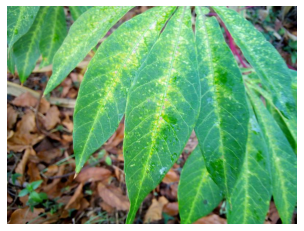

In [13]:
path = "../input/cassava-leaf-disease-classification/train_images/"
files = df_train["image_id"].tolist()
file = random.choice(files)
image = Image.open(path + file)
plt.imshow(image)
plt.axis("off")
plt.show()

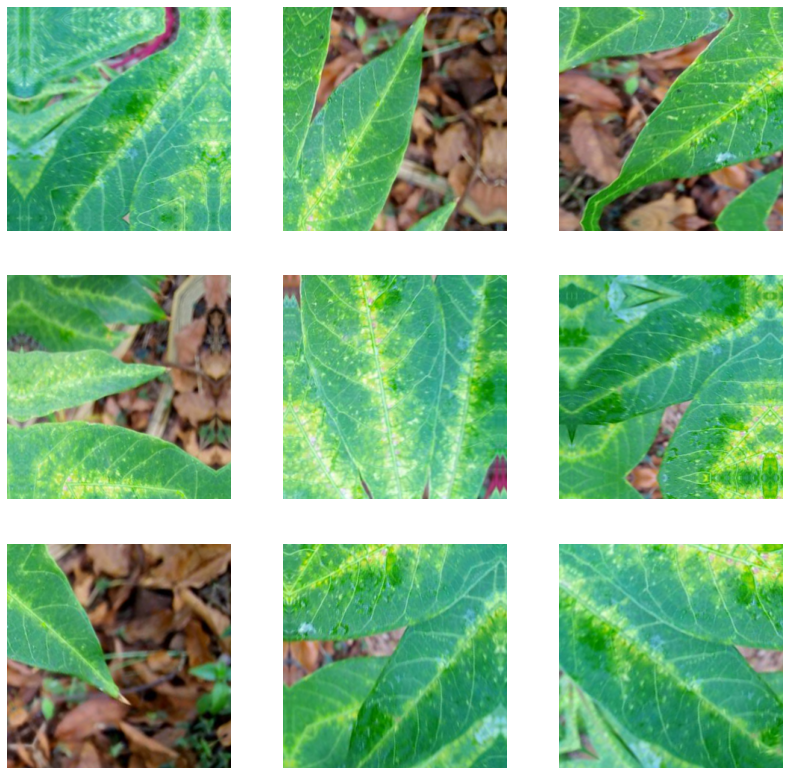

In [14]:
image = tf.expand_dims(np.array(image), 0)

plt.figure(figsize=(14, 14))
for i in range(9):
    augmented_image = img_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

## Image Augmentation (Albumentations)

In [15]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-lerqcr_i
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-lerqcr_i
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29531 sha256=b71bc7b6d970e0687b7a7283d24970a60f02b2d2edeb2ea6a37b1bd96009a24a
  Stored in directory: /tmp/pip-ephem-wheel-cache-x7kc1h_m/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor


In [16]:
from ImageDataAugmentor.image_data_augmentor import *
import albumentations as A

train_augmentations = A.Compose([
            A.RandomCrop(image_size, image_size, p=1),
            A.CoarseDropout(p=0.5),
            A.Cutout(p=0.5),
            A.Flip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.HueSaturationValue(p=0.5, hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2),
            A.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2,0.2), contrast_limit=(-0.2, 0.2)),
            A.ToFloat()
            ], p=1)

val_augmentations = A.Compose([
                A.CenterCrop(image_size, image_size, p=1),
                A.ToFloat()
                ], p=1)

In [17]:
def TFDataGenerator(train_set, val_set):
    
    train_generator = ImageDataAugmentor(augment=train_augmentations)
    val_generator = ImageDataAugmentor(augment=val_augmentations)
    
    train_datagen = train_generator.flow_from_dataframe(
                  dataframe = train_set,
                  directory='../input/cassava-leaf-disease-classification/train_images',
                  x_col='image_id',
                  y_col='label',
                  target_size=target_size,
                  batch_size=batch_size,
                  shuffle=True,
                  class_mode='categorical',
                  seed=2020)

    val_datagen = val_generator.flow_from_dataframe(
                dataframe = val_set,
                directory='../input/cassava-leaf-disease-classification/train_images',
                x_col='image_id',
                y_col='label',
                target_size=target_size,
                batch_size=batch_size,
                shuffle=False,
                class_mode='categorical',
                seed=2020)
    
    return train_datagen, val_datagen

In [18]:
train_set = df_train.iloc[:10]
val_set = df_train.iloc[-10:]

train_datagen, val_datagen = TFDataGenerator(train_set, val_set)

Found 10 validated image filenames belonging to 5 classes.
Found 10 validated image filenames belonging to 4 classes.


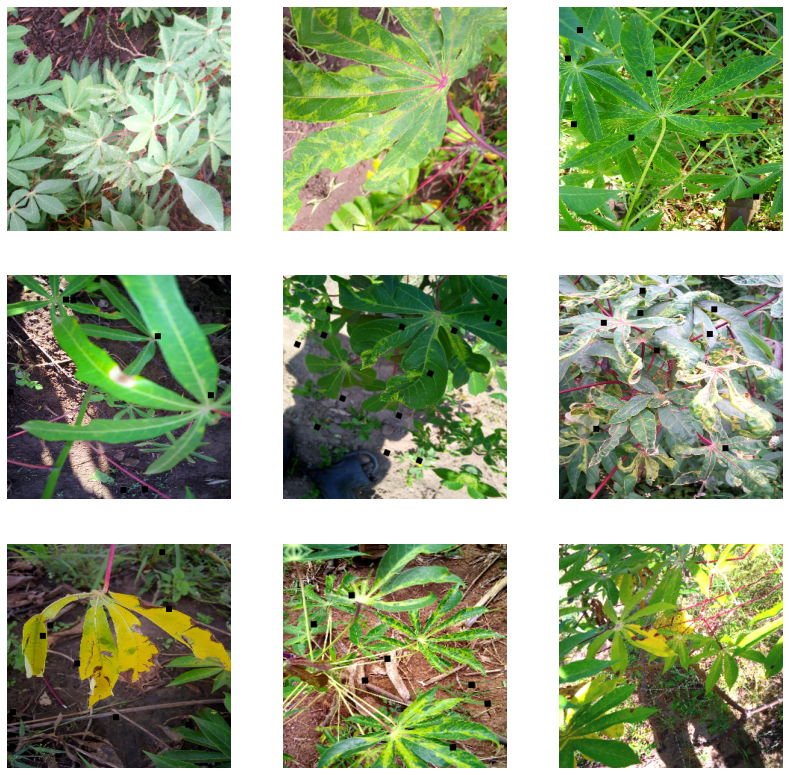

In [19]:
train_images, _ = next(train_datagen)

plt.figure(figsize=(14, 14))
for i in range(9):
    image = train_images[i]
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis("off")

plt.show()

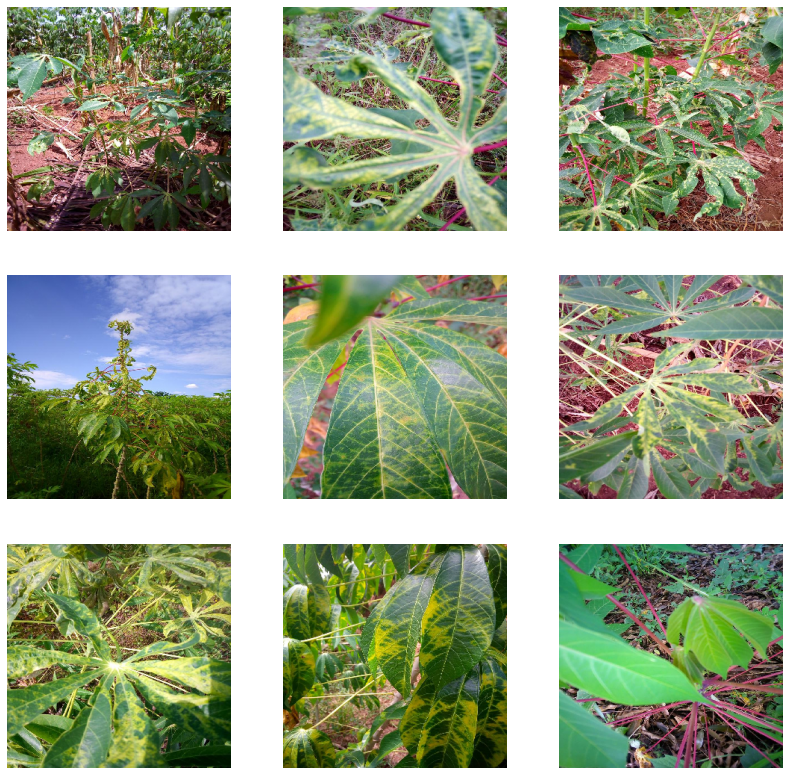

In [20]:
val_images, _ = next(val_datagen)

plt.figure(figsize=(14, 14))
for i in range(9):
    image = val_images[i]
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis("off")

plt.show()

## Model Building and Selection

In [21]:
def create_cnn():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    # Compile
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=10e-5), metrics=['accuracy'])
    return model

In [22]:
def create_vgg16():
    
    model = Sequential()
    model.add(VGG16(input_shape = input_shape, include_top = False, weights = 'imagenet'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation = 'softmax',dtype='float32')) #this is very important to use mixed_precision

    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True,
                                               label_smoothing=0.2,
                                               name='categorical_crossentropy' )
    
        # Compile
    model.compile(loss=loss, optimizer=keras.optimizers.Adam(lr=1e-3), metrics=['accuracy'])
    return model

In [23]:
def create_Inception():
    base_model = InceptionV3(include_top=False, weights="imagenet", input_shape=input_shape)

    # Rebuild top
    inputs = Input(shape=input_shape)

    model = base_model(inputs)
    pooling = GlobalAveragePooling2D()(model)
    dropout = Dropout(0.2)(pooling)

    outputs = Dense(5, activation="softmax", name="dense", dtype='float32')(dropout)

    # Compile
    inception = Model(inputs=inputs, outputs=outputs)
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2, from_logits=True)

    inception.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return inception

In [24]:
def create_Xception():
    base_model = Xception(include_top=False, weights="imagenet", input_shape=input_shape)

    # Rebuild top
    inputs = Input(shape=input_shape)

    model = base_model(inputs)
    pooling = GlobalAveragePooling2D()(model)
    dropout = Dropout(0.2)(pooling)

    outputs = Dense(5, activation="softmax", name="dense", dtype='float32')(dropout)

    # Compile
    xception = Model(inputs=inputs, outputs=outputs)
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2, from_logits=True)

    xception.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return xception

In [25]:
def create_EfficientNetB3():
    
    model = Sequential()
    model.add(EfficientNetB3(input_shape = input_shape, include_top = False, weights = 'imagenet'))
    model.add(GlobalAveragePooling2D())
    #model.add(Dense(64, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation = 'softmax',dtype='float32'))

    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True,
                                               label_smoothing=0.2,
                                               name='categorical_crossentropy' )
    
    # Compile
    model.compile(loss=loss, optimizer=keras.optimizers.Adam(lr=1e-3), metrics=['accuracy'])
    return model 

## Training with Stratified K-Fold Cross Validation

In [26]:
def plot_result(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))

    plt.figure(figsize=(15, 5))
    plt.plot(epochs, acc, 'b*-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r*-', label='Validation accuracy')
    plt.grid()
    plt.title('Training and validation accuracy')
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.figure()
    plt.show()

    plt.figure(figsize=(15, 5))
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(epochs, loss, 'b*-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
    plt.grid()
    plt.title('Training and validation loss')
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.figure()
    plt.show()

In [28]:
fold_number = 0
n_splits = 2
epochs = 8

tf.keras.backend.clear_session()
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.1, random_state=2020)
for train_index, val_index in sss.split(df_train["image_id"], df_train["label"]):
    train_set = df_train.loc[train_index]
    val_set = df_train.loc[val_index]
    train_datagen, val_datagen = TFDataGenerator(train_set, val_set)
    model = create_cnn()
    print("Training fold no.: " + str(fold_number+1))

    model_name = "cnn"
    fold_name = "fold.h5"
    filepath = model_name + str(fold_number+1) + fold_name
    callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.2),
                 EarlyStopping(monitor='val_loss', patience=3),
                 ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)]

    history1 = model.fit(train_datagen, epochs=epochs, validation_data=val_datagen, callbacks=callbacks)
    fold_number += 1
    if fold_number == n_splits:
        print("Training finished!")

Found 19257 validated image filenames belonging to 5 classes.
Found 2140 validated image filenames belonging to 5 classes.
Training fold no.: 1
Epoch 1/8
1204/1204 [==============================] - 441s 362ms/step - loss: 1.1529 - accuracy: 0.6062 - val_loss: 0.9864 - val_accuracy: 0.6481
Epoch 2/8
1204/1204 [==============================] - 276s 229ms/step - loss: 0.9735 - accuracy: 0.6460 - val_loss: 0.8803 - val_accuracy: 0.6752
Epoch 3/8
1204/1204 [==============================] - 278s 231ms/step - loss: 0.9008 - accuracy: 0.6647 - val_loss: 0.8328 - val_accuracy: 0.6706
Epoch 4/8
1204/1204 [==============================] - 277s 230ms/step - loss: 0.8416 - accuracy: 0.6877 - val_loss: 0.7672 - val_accuracy: 0.7028
Epoch 5/8
1204/1204 [==============================] - 272s 226ms/step - loss: 0.8021 - accuracy: 0.7015 - val_loss: 0.7482 - val_accuracy: 0.7164
Epoch 6/8
1204/1204 [==============================] - 278s 231ms/step - loss: 0.7707 - accuracy: 0.7102 - val_loss: 0.76

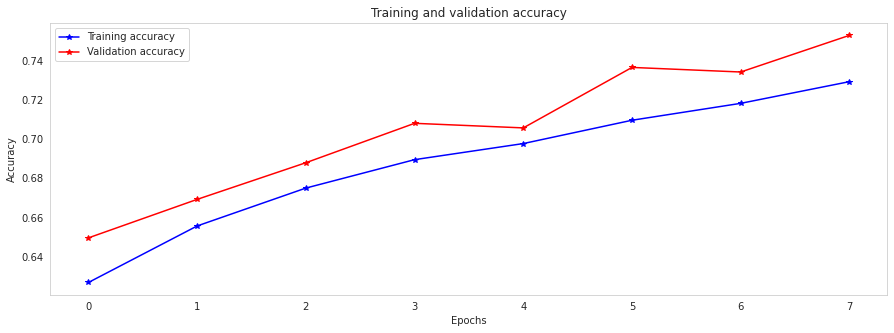

<Figure size 432x288 with 0 Axes>

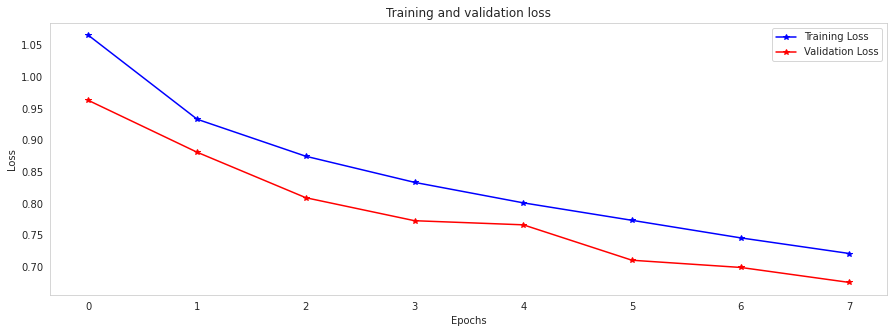

<Figure size 432x288 with 0 Axes>

In [29]:
plot_result(history1)

In [ ]:
# fold_number = 0
# n_spilts = 2
# epochs = 8

# tf.keras.backend.clear_session()
# sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.1, random_state=2020)
# for train_index, val_index in sss.split(df_train["image_id"], df_train["label"]):
#     train_set = df_train.loc[train_index]
#     val_set = df_train.loc[val_index]
#     train_datagen, val_datagen = TFDataGenerator(train_set, val_set)
#     model = create_vgg16()
#     print("Training fold no.: " + str(fold_number+1))

#     model_name = "vgg16"
#     fold_name = "fold.h5"
#     filepath = model_name + str(fold_number+1) + fold_name
#     callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.2),
#                  EarlyStopping(monitor='val_loss', patience=3),
#                  ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)]

#     history2 = model.fit(train_datagen, epochs=epochs, validation_data=val_datagen, callbacks=callbacks)
#     fold_number += 1
#     if fold_number == n_splits:
#         print("Training finished!")

In [ ]:
# plot_result(history2)

In [31]:
fold_number = 0
n_splits = 2
epochs = 8

tf.keras.backend.clear_session()
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.1, random_state=2020)
for train_index, val_index in sss.split(df_train["image_id"], df_train["label"]):
    train_set = df_train.loc[train_index]
    val_set = df_train.loc[val_index]
    train_datagen, val_datagen = TFDataGenerator(train_set, val_set)
    model = create_Inception()
    print("Training fold no.: " + str(fold_number+1))

    model_name = "inception "
    fold_name = "fold.h5"
    filepath = model_name + str(fold_number+1) + fold_name
    callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.2),
                 EarlyStopping(monitor='val_loss', patience=3),
                 ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)]

    history3 = model.fit(train_datagen, epochs=epochs, validation_data=val_datagen, callbacks=callbacks)
    fold_number += 1
    if fold_number == n_splits:
        print("Training finished!")

Found 19257 validated image filenames belonging to 5 classes.
Found 2140 validated image filenames belonging to 5 classes.
87916544/87910968 [==============================] - 1s 0us/step
Training fold no.: 1
Epoch 1/8
1204/1204 [==============================] - 338s 272ms/step - loss: 1.1262 - accuracy: 0.7119 - val_loss: 0.9526 - val_accuracy: 0.8168
Epoch 2/8
1204/1204 [==============================] - 315s 262ms/step - loss: 0.9521 - accuracy: 0.8240 - val_loss: 1.0378 - val_accuracy: 0.7710

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
Epoch 3/8
1204/1204 [==============================] - 319s 265ms/step - loss: 0.8957 - accuracy: 0.8572 - val_loss: 0.8899 - val_accuracy: 0.8570
Epoch 4/8
1204/1204 [==============================] - 322s 267ms/step - loss: 0.8684 - accuracy: 0.8746 - val_loss: 0.8699 - val_accuracy: 0.8692
Epoch 5/8
1204/1204 [==============================] - 315s 261ms/step - loss: 0.8645 - accuracy: 0.8777 - val_loss: 0.868

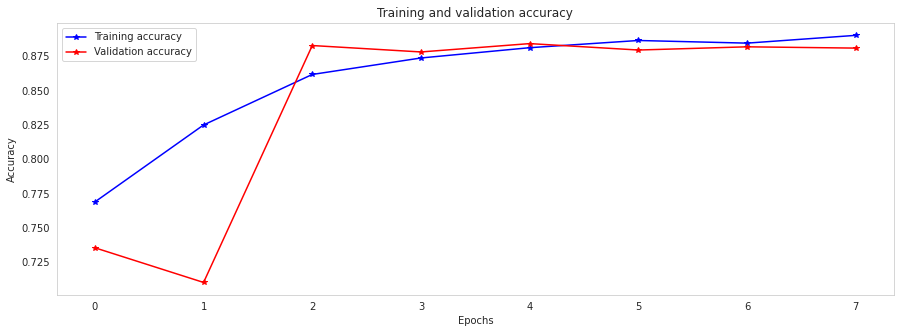

<Figure size 432x288 with 0 Axes>

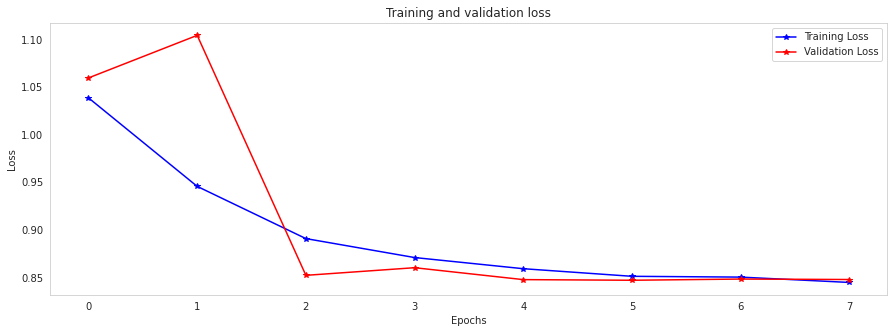

<Figure size 432x288 with 0 Axes>

In [32]:
plot_result(history3)

In [ ]:
# fold_number = 0
# n_splits = 2
# epochs = 8

# tf.keras.backend.clear_session()
# sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.1, random_state=2020)
# for train_index, val_index in sss.split(df_train["image_id"], df_train["label"]):
#     train_set = df_train.loc[train_index]
#     val_set = df_train.loc[val_index]
#     train_datagen, val_datagen = TFDataGenerator(train_set, val_set)
#     model = create_Xception()
#     print("Training fold no.: " + str(fold_number+1))

#     model_name = "xception "
#     fold_name = "fold.h5"
#     filepath = model_name + str(fold_number+1) + fold_name
#     callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.2),
#                  EarlyStopping(monitor='val_loss', patience=3),
#                  ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)]

#     history4 = model.fit(train_datagen, epochs=epochs, validation_data=val_datagen, callbacks=callbacks)
#     fold_number += 1
#     if fold_number == n_splits:
#         print("Training finished!")

In [ ]:
# plot_result(history4)

In [33]:
fold_number = 0
n_splits = 2
epochs = 8

tf.keras.backend.clear_session()
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.1, random_state=2020)
for train_index, val_index in sss.split(df_train["image_id"], df_train["label"]):
    train_set = df_train.loc[train_index]
    val_set = df_train.loc[val_index]
    train_datagen, val_datagen = TFDataGenerator(train_set, val_set)
    model = create_EfficientNetB3()
    print("Training fold no.: " + str(fold_number+1))

    model_name = "efficientnetb3"
    fold_name = "fold.h5"
    filepath = model_name + str(fold_number+1) + fold_name
    callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.2),
                 EarlyStopping(monitor='val_loss', patience=3),
                 ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)]

    history5 = model.fit(train_datagen, epochs=epochs, validation_data=val_datagen, callbacks=callbacks)
    fold_number += 1
    if fold_number == n_splits:
        print("Training finished!")

Found 19257 validated image filenames belonging to 5 classes.
Found 2140 validated image filenames belonging to 5 classes.
43941888/43941136 [==============================] - 0s 0us/step
Training fold no.: 1
Epoch 1/8
1204/1204 [==============================] - 595s 473ms/step - loss: 1.1108 - accuracy: 0.7186 - val_loss: 2.1412 - val_accuracy: 0.1210
Epoch 2/8
1204/1204 [==============================] - 563s 467ms/step - loss: 0.9702 - accuracy: 0.8079 - val_loss: 2.0294 - val_accuracy: 0.1206
Epoch 3/8
1204/1204 [==============================] - 560s 465ms/step - loss: 0.9415 - accuracy: 0.8273 - val_loss: 1.7938 - val_accuracy: 0.1355
Epoch 4/8
1204/1204 [==============================] - 563s 467ms/step - loss: 0.9240 - accuracy: 0.8340 - val_loss: 2.1941 - val_accuracy: 0.1206

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/8
1204/1204 [==============================] - 562s 466ms/step - loss: 0.8842 - accuracy: 0.8614 - val_loss: 1.88

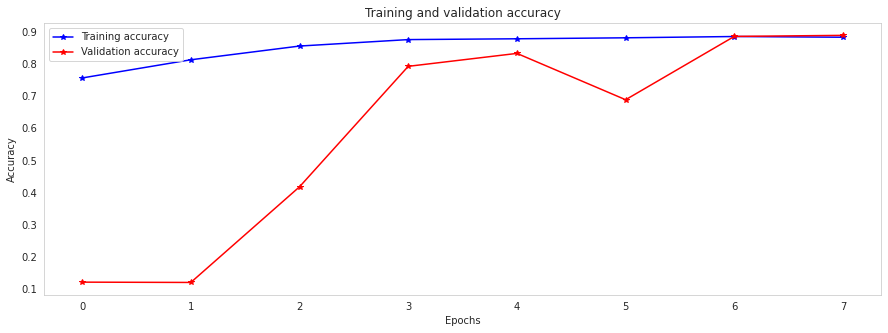

<Figure size 432x288 with 0 Axes>

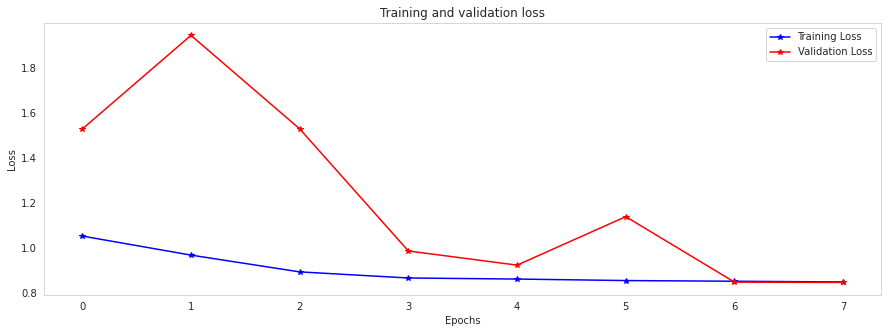

<Figure size 432x288 with 0 Axes>

In [34]:
plot_result(history5)

## Model Ensembling and Inference

In [ ]:
n_splits = 2
models = []
for i in range(n_splits):
    inception = load_model("./inception" + str(i+1) + "fold.h5")
    models.append(inception)
    
for i in range(n_splits):
    efficientnetb3 = load_model("./efficientnetb3" + str(i+1) + "fold.h5")
    models.append(efficientnetb3)